Generate the DFA from the NFA in the following problem. The problem is to detect all the strings from 0s and 1s such that foutrh symbol from the end is 1. The NFA is as follows where n = 4.

In [ ]:
!pip install visual-automata

In [ ]:
import numpy as np

In [ ]:
"""Classes and methods for working with visual deterministic finite automata."""

from typing import Union
import os

import pandas as pd
from pandas import DataFrame
from automata.fa.dfa import DFA
from colormath.color_objects import sRGBColor
from graphviz import Digraph
from IPython.display import display

from visual_automata.colors import (
    create_palette,
    hex_to_rgb_color,
    list_cycler,
)


class VisualDFA:
    """A wrapper for an automata-lib deterministic finite automaton."""

    def __init__(
        self,
        dfa: DFA = None,
        *,
        states: set = None,
        input_symbols: set = None,
        transitions: dict = None,
        initial_state: str = None,
        final_states: set = None
    ):

        if dfa:
            self.dfa = dfa
        else:
            self.dfa = DFA(
                states=states,
                input_symbols=input_symbols,
                transitions=transitions,
                initial_state=initial_state,
                final_states=final_states,
            )

    # -------------------------------------------------------------------------
    # Mimic behavior of automata-lib DFA.

    @property
    def states(self):
        """Pass on .states from the DFA"""
        return self.dfa.states

    @states.setter
    def states(self, states: set):
        """Set .states on the DFA"""
        self.dfa.states = states

    @property
    def input_symbols(self):
        """Pass on .input_symbols from the DFA"""
        return self.dfa.input_symbols

    @input_symbols.setter
    def input_symbols(self, input_symbols: set):
        """Set .input_symbols on the DFA"""
        self.dfa.input_symbols = input_symbols

    @property
    def transitions(self):
        """Pass on .transitions from the DFA"""
        return self.dfa.transitions

    @transitions.setter
    def transitions(self, transitions: dict):
        """Set .transitions on the DFA"""
        self.dfa.transitions = transitions

    @property
    def initial_state(self):
        """Pass on .initial_state from the DFA"""
        return self.dfa.initial_state

    @initial_state.setter
    def initial_state(self, initial_state: str):
        """Set .initial_state on the DFA"""
        self.dfa.initial_state = initial_state

    @property
    def final_states(self):
        """Pass on .final_states from the DFA"""
        return self.dfa.final_states

    @final_states.setter
    def final_states(self, final_states: set):
        """Set .final_states on the DFA"""
        self.dfa.final_states = final_states

    def copy(self) -> DFA:
        """Create a deep copy of the automaton."""
        return self.__class__(**vars(self))

    def minify(self) -> DFA:
        """
        Create a minimal DFA which accepts the same inputs as this DFA.
        First, non-reachable states are removed.
        Then, similar states are merged using Hopcroft's Algorithm.
        retain_names: If True, merged states retain names.
                      If False, new states will be named 0, ..., n-1.

        Returns:
            DFA: A new minimal VisualDFA, if applicable.
        """
        new_dfa = self.dfa.copy()
        new_dfa = new_dfa.minify()
        new_dfa = VisualDFA(new_dfa)
        return new_dfa

    # -------------------------------------------------------------------------
    # Define new attributes.

    @property
    def table(self) -> DataFrame:
        """
        Generates a transition table of the given VisualDFA.

        Returns:
            DataFrame: A transition table of the VisualDFA.
        """
        initial_state = self.initial_state
        final_states = [str(x) for x in self.final_states]
        transitions = self.__transition_sort(self.transitions)

        table: dict = {}
        for state, transition in transitions.items():
            if state == initial_state and state in final_states:
                state = "→*" + state
            elif state == initial_state:
                state = "→" + state
            elif state in final_states:
                state = "*" + state

            row: dict = {}
            for input_symbol, next_state in transition.items():
                if next_state in final_states:
                    row[input_symbol] = "*" + next_state
                else:
                    row[input_symbol] = next_state
            table[state] = row

        table = pd.DataFrame.from_dict(table).T

        return table

    def __str__(self) -> str:
        return self.table.to_string()

    def __repr__(self) -> str:
        return self.table.to_string()

    # -------------------------------------------------------------------------
    # Adapt behavior of automata-lib DFA.

    # Works like DFA._get_next_current_state, without raising exceptions.
    # Defined as a an internal/private method, prefixed with "__" instead of "_".
    def __get_next_current_state(
        self, current_state: str, input_symbol: str
    ) -> str:
        """
        Follow the transition for the given input symbol on the current state.

        Args:
            current_state (str): Current state.
            input_symbol (str): Input symbol.

        Returns:
            str: The next current state after entering input symbol.
        """
        if input_symbol in self.dfa.transitions[current_state]:
            return self.dfa.transitions[current_state][input_symbol]

    # -------------------------------------------------------------------------
    # Define helper methods.

    @staticmethod
    def __transition_sort(transitions: dict) -> dict:
        """
        Sorts the transitions dictionary.

        Args:
            transitions (dict): Unsorted transitions.

        Returns:
            dict: Sorted transitions.
        """
        transitions = dict(
            sorted(
                transitions.items(),
                key=lambda k: k[0].replace("{", "").replace("}", ""),
            )
        )
        for state, transition in transitions.items():
            transitions[state] = dict(sorted(transition.items()))

        return transitions

    @staticmethod
    def __transitions_pairs(transitions: dict) -> list:
        """
        Generates a list of all possible transitions pairs for all input symbols.

        Args:
            transition_dict (dict): DFA transitions.

        Returns:
            list: All possible transitions for all the given input symbols.
        """
        transition_possibilities: list = []
        for state, transitions in transitions.items():
            for symbol, transition in transitions.items():
                transition_possibilities.append((state, transition, symbol))
        return transition_possibilities

    @staticmethod
    def __transition_steps(
        initial_state, final_states, input_str: str, transitions_taken: list, status: bool
    ) -> DataFrame:
        """
        Generates a table of taken transitions based on the input string and it's result.

        Args:
            initial_state (str): The DFA's initial state.
            final_states (set): The DFA's final states.
            input_str (str): The input string to run on the DFA.
            transitions_taken (list): Transitions taken from the input string.
            status (bool): The result of the input string.

        Returns:
            DataFrame: Table of taken transitions based on the input string and it's result.
        """
        current_states = transitions_taken.copy()
        for i, state in enumerate(current_states):
            if (
                state == initial_state and state in
                final_states
            ):
                current_states[i] = "→*" + state
            elif state == initial_state:
                current_states[i] = "→" + state
            elif state in final_states:
                current_states[i] = "*" + state

        new_states = current_states.copy()
        del current_states[-1]
        del new_states[0]
        inputs = [str(x) for x in input_str]

        transition_steps: dict = {
            "Current state:": current_states,
            "Input symbol:": inputs,
            "New state:": new_states,
        }

        transition_steps = pd.DataFrame.from_dict(
            transition_steps
        )
        transition_steps.index += 1
        transition_steps = pd.DataFrame.from_dict(
            transition_steps
        ).rename_axis("Step:", axis=1)
        if status:
            transition_steps.columns = pd.MultiIndex.from_product(
                [["[Accepted]"], transition_steps.columns]
            )
            return transition_steps
        else:
            transition_steps.columns = pd.MultiIndex.from_product(
                [["[Rejected]"], transition_steps.columns]
            )
            return transition_steps

    # -------------------------------------------------------------------------
    # Define new features.

    def input_check(
        self, input_str: str, return_result=False
    ) -> Union[bool, list, list]:
        """
        Checks if string of input symbols results in final state.

        Args:
            input_str (str): The input string to run on the DFA.
            return_result (bool, optional): Returns results to the show_diagram method. Defaults to False.

        Raises:
            TypeError: To let the user know a string has to be entered.

        Returns:
            Union[bool, list, list]: If the last state is the final state, transition pairs, and steps taken.
        """
        if not isinstance(input_str, str):
            raise TypeError(f"input_str should be a string. {input_str} is {type(input_str)}, not a string.")

        current_state = self.dfa.initial_state
        transitions_taken = [current_state]
        symbol_sequence: list = []
        status: bool = True

        for symbol in input_str:
            symbol_sequence.append(symbol)
            current_state = self.__get_next_current_state(
                current_state, symbol
            )
            transitions_taken.append(current_state)

        if transitions_taken[-1] not in self.dfa.final_states:
            status = False
        else:
            status = True

        taken_transitions_pairs = [
            (a, b, c)
            for a, b, c in zip(
                transitions_taken, transitions_taken[1:], symbol_sequence
            )
        ]
        taken_steps = self.__transition_steps(
            initial_state=self.dfa.initial_state,
            final_states=self.dfa.final_states,
            input_str=input_str,
            transitions_taken=transitions_taken,
            status=status,
        )
        if return_result:
            return status, taken_transitions_pairs, taken_steps
        else:
            return taken_steps  # .to_string(index=False)

    def show_diagram(
        self,
        input_str: str = None,
        filename: str = None,
        format_type: str = "png",
        path: str = None,
        *,
        view=False,
        cleanup: bool = True,
        horizontal: bool = True,
        reverse_orientation: bool = False,
        fig_size: tuple = (100, 100),
        font_size: float = 12.0,
        arrow_size: float = 0.4,
        state_seperation: float = 0.5,
    ) -> Digraph:
        """
        Generates the graph associated with the given DFA.

        Args:
            dfa (DFA): Deterministic Finite Automata to graph.
            input_str (str, optional): String list of input symbols. Defaults to None.
            filename (str, optional): Name of output file. Defaults to None.
            format_type (str, optional): File format [svg/png/...]. Defaults to "png".
            path (str, optional): Folder path for output file. Defaults to None.
            view (bool, optional): Storing and displaying the graph as a pdf. Defaults to False.
            cleanup (bool, optional): Garbage collection. Defaults to True.
            horizontal (bool, optional): Direction of node layout. Defaults to True.
            reverse_orientation (bool, optional): Reverse direction of node layout. Defaults to False.
            fig_size (tuple, optional): Figure size. Defaults to (8, 8).
            font_size (float, optional): Font size. Defaults to 14.0.
            arrow_size (float, optional): Arrow head size. Defaults to 0.85.
            state_seperation (float, optional): Node distance. Defaults to 0.5.

        Returns:
            Digraph: The graph in dot format.
        """
        # Converting to graphviz preferred input type,
        # keeping the conventional input styles; i.e fig_size(8,8)
        fig_size = ", ".join(map(str, fig_size))
        font_size = str(font_size)
        arrow_size = str(arrow_size)
        state_seperation = str(state_seperation)

        # Defining the graph.
        graph = Digraph(strict=False)
        graph.attr(
            size=fig_size,
            ranksep=state_seperation,
        )
        if horizontal:
            graph.attr(rankdir="LR")
        if reverse_orientation:
            if horizontal:
                graph.attr(rankdir="RL")
            else:
                graph.attr(rankdir="BT")

        # Defining arrow to indicate the initial state.
        graph.node("Initial", label="", shape="point", fontsize=font_size)

        # Defining all states.
        for state in sorted(self.dfa.states):
            if (
                state in self.dfa.initial_state and state in
                self.dfa.final_states
            ):
                graph.node(state, shape="doublecircle", fontsize=font_size)
            elif state in self.dfa.initial_state:
                graph.node(state, shape="circle", fontsize=font_size)
            elif state in self.dfa.final_states:
                graph.node(state, shape="doublecircle", fontsize=font_size)
            else:
                graph.node(state, shape="circle", fontsize=font_size)

        # Point initial arrow to the initial state.
        graph.edge("Initial", self.dfa.initial_state, arrowsize=arrow_size)

        # Define all tansitions in the finite state machine.
        all_transitions_pairs = self.__transitions_pairs(self.dfa.transitions)

        if input_str is None:
            for pair in all_transitions_pairs:
                graph.edge(
                    pair[0],
                    pair[1],
                    label=" {} ".format(pair[2]),
                    arrowsize=arrow_size,
                    fontsize=font_size,
                )
            status = None

        else:
            status, taken_transitions_pairs, taken_steps = self.input_check(
                input_str=input_str, return_result=True
            )
            remaining_transitions_pairs = [
                x
                for x in all_transitions_pairs
                if x not in taken_transitions_pairs
            ]

            # Define color palette for transitions
            if status:
                start_color = hex_to_rgb_color("#FFFF00")
                end_color = hex_to_rgb_color("#00FF00")
            else:
                start_color = hex_to_rgb_color("#FFFF00")
                end_color = hex_to_rgb_color("#FF0000")
            number_of_colors = len(input_str)
            palette = create_palette(
                start_color, end_color, number_of_colors, sRGBColor
            )
            color_gen = list_cycler(palette)

            # Define all tansitions in the finite state machine with traversal.
            counter = 0
            for pair in taken_transitions_pairs:
                counter += 1
                edge_color = next(color_gen)
                graph.edge(
                    pair[0],
                    pair[1],
                    label=" [{}]\n{} ".format(counter, pair[2]),
                    arrowsize=arrow_size,
                    fontsize=font_size,
                    color=edge_color,
                    penwidth="2.5",
                )

            for pair in remaining_transitions_pairs:
                graph.edge(
                    pair[0],
                    pair[1],
                    label=" {} ".format(pair[2]),
                    arrowsize=arrow_size,
                    fontsize=font_size,
                )

        # Write diagram to file. PNG, SVG, etc.
        if filename:
            graph.render(
                filename=filename,
                format=format_type,
                directory=path,
                cleanup=cleanup,
            )

        if view:
            graph.render(view=True)
        if input_str:
            display(taken_steps)
            return graph
        else:
            return graph

    # -------------------------------------------------------------------------


In [ ]:
conv = {('q0',): "q0",
 ('q0', 'q1'): "q0-q1",
 ('q0', 'q2'): "q0-q2",
 ('q0', 'q1', 'q2'): "q0-q1-q2",
 ('q0', 'q3'): "q0-q3",
 ('q0', 'q1', 'q3'): "q0-q1-q3",
 ('q0', 'q2', 'q3'): "q0-q2-q3",
 ('q0', 'q1', 'q2', 'q3'): "q0-q1-q2-q3",
 ('q0', 'q4'): "q0-q4",
 ('q0', 'q1', 'q4'): "q0-q1-q4",
 ('q0', 'q2', 'q4'): "q0-q2-q4",
 ('q0', 'q1', 'q2', 'q4'): "q0-q1-q2-q4",
 ('q0', 'q3', 'q4'): "q0-q3-q4",
 ('q0', 'q1', 'q3', 'q4'): "q0-q1-q3-q4",
 ('q0', 'q2', 'q3', 'q4'): "q0-q2-q3-q4",
 ('q0', 'q1', 'q2', 'q3', 'q4'): "q0-q1-q2-q3-q4"}

In [ ]:
NFA = {
('q0', 0) : ['q0'],
('q0', 1) : ['q0', 'q1'],
('q1', 0) : ['q2'],
('q1', 1) : ['q2'],
('q2', 0) : ['q3'],
('q2', 1) : ['q3'],
('q3', 0) : ['q4'],
('q3', 1) : ['q4'],
('q4', 0) : [],
('q4', 1) : [],
}
start_state = 'q0'
final_states = ['q4']

In [ ]:
[NFA[(i,0)] for i in ['q0', 'q1']]

[['q0'], ['q2']]

In [ ]:
def NFA_To_DFA(NFA, start_state, final_states):
  final_states_DFA=[]
  dfa={}
  states=[tuple(NFA[(start_state,0)]), tuple(NFA[(start_state,1)])]
  for i in range(30):
    x = states[i]
    dfa[conv[x]] = {"0":conv[tuple(np.unique(sum([NFA[(i,0)] for i in x], [])))], "1":conv[tuple(np.unique(sum([NFA[(i,1)] for i in x], [])))]}
    states.append(tuple(np.unique(sum([NFA[(i,0)] for i in x], []))))
    states.append(tuple(np.unique(sum([NFA[(i,1)] for i in x], []))))

  for final in final_states:
    for x in dfa.keys():
      if final in x:
        final_states_DFA.append(x)

  return dfa, start_state, set(final_states_DFA)

dfa, start_state, final_states_DFA =NFA_To_DFA(NFA, start_state, final_states)


In [ ]:
dfa = VisualDFA(
    states = set(dfa.keys()),
    input_symbols = {'0','1'},
    transitions = dfa,
    initial_state = start_state,
    final_states = final_states_DFA
)

In [ ]:
dfa

                            0                1
→q0                        q0            q0-q1
q0-q1                   q0-q2         q0-q1-q2
q0-q1-q2             q0-q2-q3      q0-q1-q2-q3
q0-q1-q2-q3      *q0-q2-q3-q4  *q0-q1-q2-q3-q4
*q0-q1-q2-q3-q4  *q0-q2-q3-q4  *q0-q1-q2-q3-q4
*q0-q1-q2-q4         q0-q2-q3      q0-q1-q2-q3
q0-q1-q3            *q0-q2-q4     *q0-q1-q2-q4
*q0-q1-q3-q4        *q0-q2-q4     *q0-q1-q2-q4
*q0-q1-q4               q0-q2         q0-q1-q2
q0-q2                   q0-q3         q0-q1-q3
q0-q2-q3            *q0-q3-q4     *q0-q1-q3-q4
*q0-q2-q3-q4        *q0-q3-q4     *q0-q1-q3-q4
*q0-q2-q4               q0-q3         q0-q1-q3
q0-q3                  *q0-q4        *q0-q1-q4
*q0-q3-q4              *q0-q4        *q0-q1-q4
*q0-q4                     q0            q0-q1

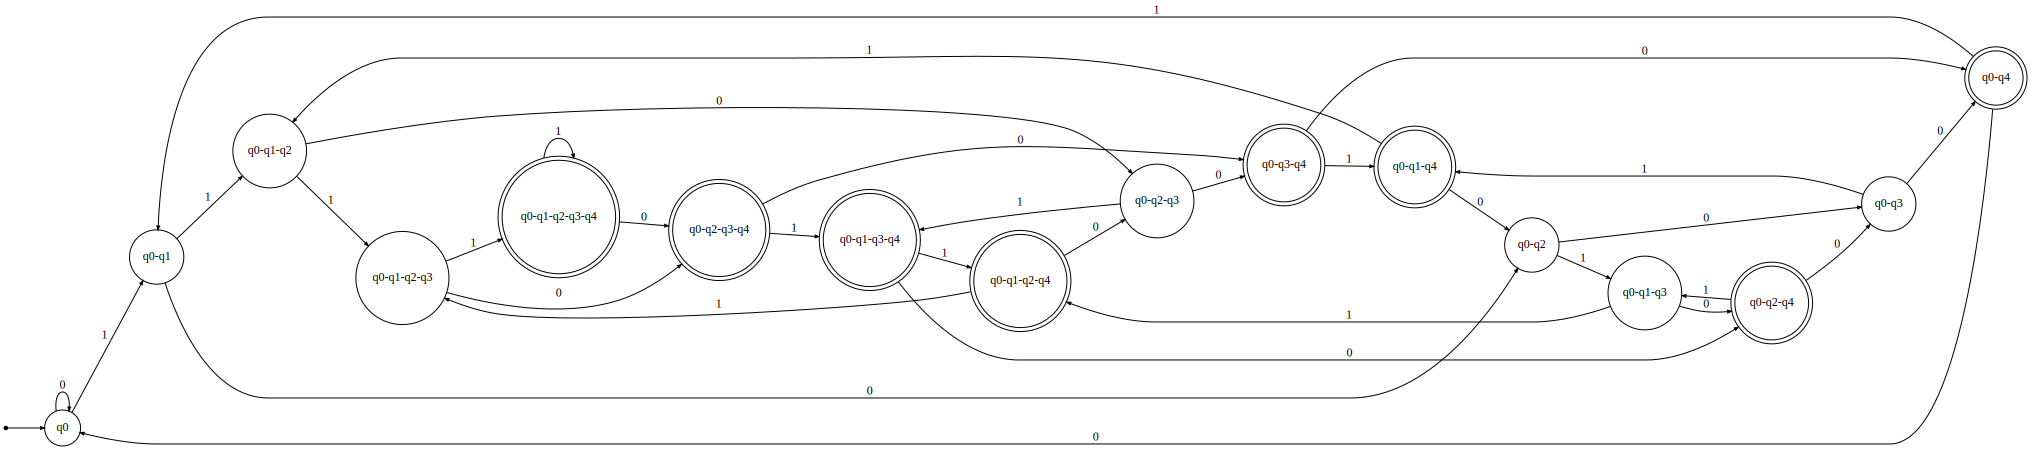

In [ ]:
dfa.show_diagram()

[Accepted]                               
Step:   Current state: Input symbol:       New state:
1                  →q0             1            q0-q1
2                q0-q1             1         q0-q1-q2
3             q0-q1-q2             1      q0-q1-q2-q3
4          q0-q1-q2-q3             1  *q0-q1-q2-q3-q4
5      *q0-q1-q2-q3-q4             0     *q0-q2-q3-q4
6         *q0-q2-q3-q4             1     *q0-q1-q3-q4
7         *q0-q1-q3-q4             1     *q0-q1-q2-q4
8         *q0-q1-q2-q4             0         q0-q2-q3
9             q0-q2-q3             0        *q0-q3-q4
10           *q0-q3-q4             1        *q0-q1-q4
11           *q0-q1-q4             0            q0-q2
12               q0-q2             1         q0-q1-q3
13            q0-q1-q3             0        *q0-q2-q4
14           *q0-q2-q4             0            q0-q3
15               q0-q3             0           *q0-q4

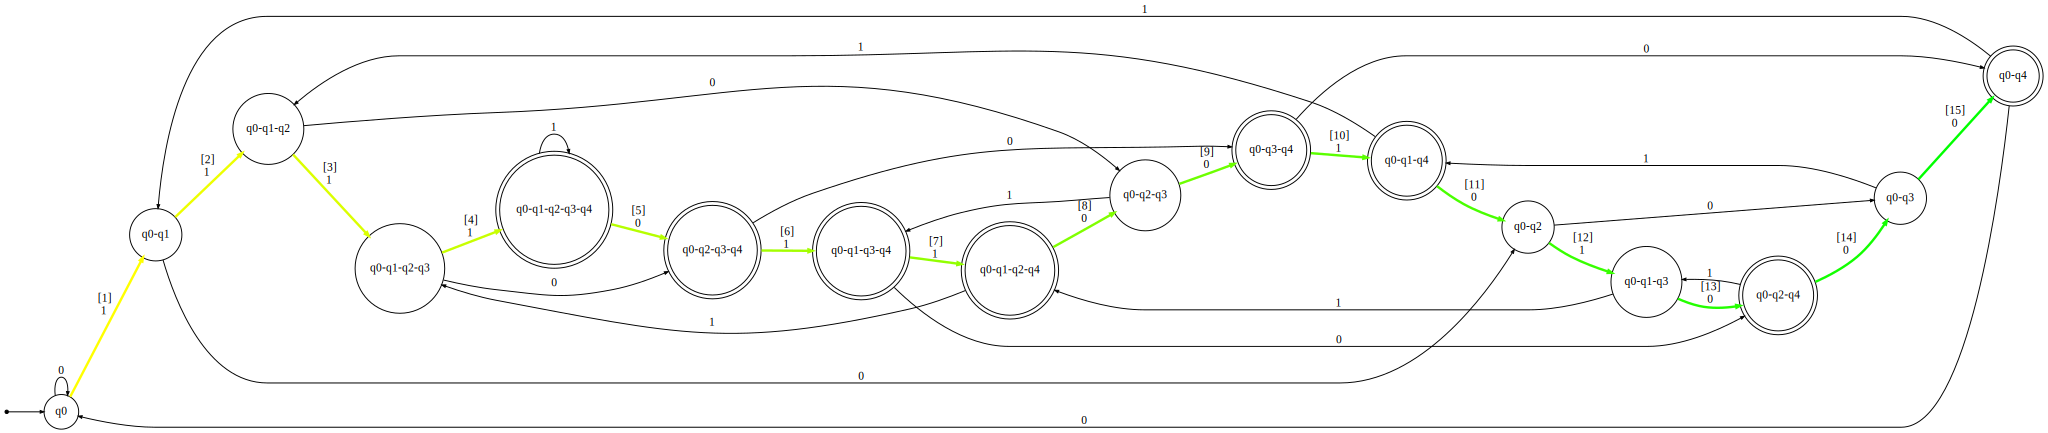

In [ ]:
#To get The string input that passes through all the states of the DFA, walk sequentially from q0 to q0-q4

#The sequence is q0 -> q0-q1 -> q0-q1-q2 -> q0-q1-q2-q3 -> q0-q1-q2-q3-q4 -> q0-q2-q3-q4 -> q0-q1-q3-q4 -> q0-q1-q2-q4 -> q0-q2-q3 -> q0-q3-q4 -> q0-q1-q4 -> q0-q2 -> q0-q1-q3 -> q0-q2-q4 -> q0-q3 -> q0-q4

dfa.show_diagram('111101100101000')